In [1]:
import copy
import gc
import numpy as np
import torch
import tensorboardX
from functools import partial
from matplotlib import pyplot as plt
from scipy.special import logsumexp
from prob_mbrl import losses, models, utils
from collections import OrderedDict
torch.set_flush_denormal(True)
torch.set_num_threads(2)

In [2]:
 class NetWithRandomPrior(models.BSequential):
    def __init__(self, model, prior, *args, **kwargs):
        super(NetWithRandomPrior, self).__init__(*args, **kwargs)
        self.model = model
        self.prior = prior
    
    def parameters(self):
        return self.model.parameters()
    
    def forward(self, x, *args, **kwargs):
        y = self.model(x, *args, **kwargs)
        if self.train:
            with torch.no_grad():
                y += self.prior(x, *args, **kwargs)
        return y
    

class ModelEnsemble(models.BSequential):
    def __init__(self, model, N_ensemble=4, head_layers=2):
        super(ModelEnsemble, self).__init__()
        self.N_ensemble = N_ensemble
        children = list(model.named_children())
        self.bottom = models.BSequential(OrderedDict(children[:-head_layers]))
        self.heads = []
        if head_layers > 0:
            head = models.BSequential(OrderedDict(children[-head_layers:]))
            for i in range(N_ensemble):
                setattr(self, 'head_%d' % i, copy.deepcopy(head))
                self.heads.append(getattr(self, 'head_%d' % i))
        self.register_buffer('head_idxs',
            torch.randint(0, N_ensemble, torch.Size([1])))
        self.last_batch = None
                
    def resample(self):
        self.update_head_idxs(self.head_idxs)

    def update_head_idxs(self, y):
        self.head_idxs.data = torch.randint(
            0, self.N_ensemble, torch.Size([y.shape[0]]))
        if self.last_batch is None or y.shape[0] != self.last_batch.shape[0]:
            # push batch through heads to initialize masks
            for head in self.heads:
                head(y, resample=False)
            self.last_batch = y
   
    def forward(self, x, *args, **kwargs):        
        y = self.bottom(x, *args, **kwargs)
        self.last_batch = y
        if len(self.heads) > 0:
            head_idxs = kwargs.get('head_idxs', self.head_idxs)
            resample = kwargs.get('resample', False)
            # get batch head masks
            if resample or x.shape[0] != self.head_idxs.shape[0]:
                self.update_head_idxs(y)
            if head_idxs is None:
                head_idxs = self.head_idxs
            # sort by head index, so we can batch them
            sorted_head_idxs, sort_idxs = head_idxs.sort()
            revert_idxs = sort_idxs.sort()[-1]
            split_head_idxs = torch.nonzero(
                sorted_head_idxs[1:] - sorted_head_idxs[:-1]).flatten()
            split_head_idxs = torch.cat([
                torch.tensor([0]),
                split_head_idxs + 1, 
                torch.tensor([sorted_head_idxs.shape[0]])])
            split_head_lens = tuple(
                int(i) for i in split_head_idxs[1:] - split_head_idxs[:-1])
            # split into per-head chunk
            chunk_idxs = sort_idxs.split(split_head_lens)
            heads_used = sorted_head_idxs[split_head_idxs[:-1]]
            # predict
            ys = [self.heads[h_idx](y[idxs], *args, **kwargs)
                  for h_idx, idxs in zip(heads_used, chunk_idxs)]
            y = torch.cat(ys)[revert_idxs]
        return y

In [3]:
def gaussian_sample(mu, log_sigma):
    z2 = np.random.randn(*mu.shape)
    return mu + z2*np.exp(log_sigma)


def mixture_sample(mu, log_sigma, logit_pi, colors=None, noise=True):
    z1 = np.random.rand(*logit_pi.shape)
    g1 = -np.log(-np.log(z1))
    k = (logit_pi - logsumexp(logit_pi, -1)[:, None] + g1).argmax(-1)
    idx = np.arange(len(mu))
    samples = mu[idx, k]
    if noise:
        z2 = np.random.randn(*mu.shape[:-1])
        samples += z2*np.exp(log_sigma[idx, k])

    if colors is not None:
        return samples, colors[k]
    return samples


def f(x, multimodal=False):
    c = 100
    if multimodal:
        c *= np.random.choice([-1, 1], x.shape[0])
    return c*sum([np.sin(-2*np.pi*(2*k-1)*x)/(2*k-1) for k in range(1, 3)])

In [4]:
# model parameters
n_layers = 16
layer_width = 200
drop_rate = 0.1
odims = 1
n_components = 5
N_batch = 100
use_cuda = False

# single gaussian output model
mlp = models.mlp(
    1,
    2 * odims, [layer_width] * n_layers,
    dropout_layers=[
        models.CDropout(2* drop_rate * np.random.rand(layer_width))
        for hid in range(n_layers)
    ],
    biases_initializer=partial(torch.nn.init.uniform_, a=-1.0e-3, b=1.0e-3),
    weights_initializer=partial(torch.nn.init.xavier_normal_,
                                gain=(1 - drop_rate) *
                                torch.nn.init.calculate_gain('relu')))
model = models.Regressor(mlp,
                         output_density=models.DiagGaussianDensity(
                             odims, max_noise_std=3.0))

# mixture density network
mlp2 = models.mlp(
    1,
    2 * n_components * odims + n_components + 1, [layer_width] * n_layers,
    biases_initializer=partial(torch.nn.init.uniform_, a=-1.0, b=1.0),
    dropout_layers=[
        models.CDropout(2*drop_rate * np.random.rand(layer_width))
        for i in range(n_layers)
    ],
    weights_initializer=partial(torch.nn.init.xavier_normal_,
                                gain=(1 - drop_rate) *
                                torch.nn.init.calculate_gain('relu')))
mmodel = models.Regressor(mlp2,
                          output_density=models.GaussianMixtureDensity(
                              odims, n_components, max_noise_std=3.0))

# optimizer for single gaussian model
opt1 = torch.optim.Adam(model.parameters(), 1e-3)

# optimizer for mixture density network
opt2 = torch.optim.Adam(mmodel.parameters(), 1e-3)

writer = tensorboardX.SummaryWriter()

('input_dims', 1)
('output_dims', 2)
('hidden_dims', [200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200])
('nonlin', <class 'torch.nn.modules.activation.ReLU'>)
('output_nonlin', None)
('dropout_layers', [CDropout(rate=[mean: 0.10164949324006345, min: 5.016736783935993e-05, max: 0.19714121549089603], regularizer_scale=0.10000000149011612), CDropout(rate=[mean: 0.09156755564750936, min: 0.0004509270195235393, max: 0.19909079033676547], regularizer_scale=0.10000000149011612), CDropout(rate=[mean: 0.09715193572484876, min: 0.0010085897595877302, max: 0.1953408727668603], regularizer_scale=0.10000000149011612), CDropout(rate=[mean: 0.09436971855307164, min: 0.0003291051723740557, max: 0.19788545504194022], regularizer_scale=0.10000000149011612), CDropout(rate=[mean: 0.10690344684653712, min: 0.006658617053759586, max: 0.19942599038851627], regularizer_scale=0.10000000149011612), CDropout(rate=[mean: 0.10482821722179271, min: 0.0008677967823070842, max: 0.199659

In [5]:
# create training dataset
train_x = np.concatenate([np.arange(-0.6, -0.25, 0.01),
                          np.arange(0.1, 0.25, 0.01),
                          np.arange(0.65, 1.0, 0.01)])
train_y = f(train_x)
train_y += 0.01*np.random.randn(*train_y.shape)
X = torch.from_numpy(train_x[:, None]).float()
Y = torch.from_numpy(train_y[:, None]).float()

model.set_dataset(X, Y)
mmodel.set_dataset(X, Y)

model = model.float()
mmodel = mmodel.float()

if use_cuda and torch.cuda.is_available():
    X = X.cuda()
    Y = Y.cuda()
    model = model.cuda()
    mmodel = mmodel.cuda()

print(('Dataset size:', train_x.shape[0], 'samples'))

('Dataset size:', 85, 'samples')


In [11]:
utils.train_regressor(
    model, iters=4000, batchsize=N_batch, resample=True, summary_writer=writer, summary_scope='single_gaussian')

log-likelihood of data: 0.884661:   0%|          | 3/4000 [00:00<02:49, 23.58it/s]

train_regressor > Dataset size [85]


log-likelihood of data: 1.108102: 100%|█████████▉| 3997/4000 [02:31<00:00, 29.97it/s]

Regressor(
  (model): BSequential(
    (fc0): Linear(in_features=1, out_features=200, bias=True)
    (nonlin0): ReLU()
    (drop0): CDropout(rate=[mean: 0.1745280772447586, min: 7.045269012451172e-05, max: 0.4213409423828125], regularizer_scale=0.10000000149011612)
    (fc1): Linear(in_features=200, out_features=200, bias=True)
    (nonlin1): ReLU()
    (drop1): CDropout(rate=[mean: 0.17286279797554016, min: 0.0005844831466674805, max: 0.41826051473617554], regularizer_scale=0.10000000149011612)
    (fc2): Linear(in_features=200, out_features=200, bias=True)
    (nonlin2): ReLU()
    (drop2): CDropout(rate=[mean: 0.1954231709241867, min: 0.0013211369514465332, max: 0.4165080189704895], regularizer_scale=0.10000000149011612)
    (fc3): Linear(in_features=200, out_features=200, bias=True)
    (nonlin3): ReLU()
    (drop3): CDropout(rate=[mean: 0.2020530104637146, min: 0.00043708086013793945, max: 0.4116508364677429], regularizer_scale=0.10000000149011612)
    (fc4): Linear(in_features=20

Regressor(
  (model): BSequential(
    (fc0): Linear(in_features=1, out_features=200, bias=True)
    (nonlin0): ReLU()
    (drop0): CDropout(rate=[mean: 0.14973779022693634, min: 6.556510925292969e-05, max: 0.3367387056350708], regularizer_scale=0.10000000149011612)
    (fc1): Linear(in_features=200, out_features=200, bias=True)
    (nonlin1): ReLU()
    (drop1): CDropout(rate=[mean: 0.14343364536762238, min: 0.0005881786346435547, max: 0.3336418867111206], regularizer_scale=0.10000000149011612)
    (fc2): Linear(in_features=200, out_features=200, bias=True)
    (nonlin2): ReLU()
    (drop2): CDropout(rate=[mean: 0.159005805850029, min: 0.0013288259506225586, max: 0.331892728805542], regularizer_scale=0.10000000149011612)
    (fc3): Linear(in_features=200, out_features=200, bias=True)
    (nonlin3): ReLU()
    (drop3): CDropout(rate=[mean: 0.16044746339321136, min: 0.0004164576530456543, max: 0.33181047439575195], regularizer_scale=0.10000000149011612)
    (fc4): Linear(in_features=200

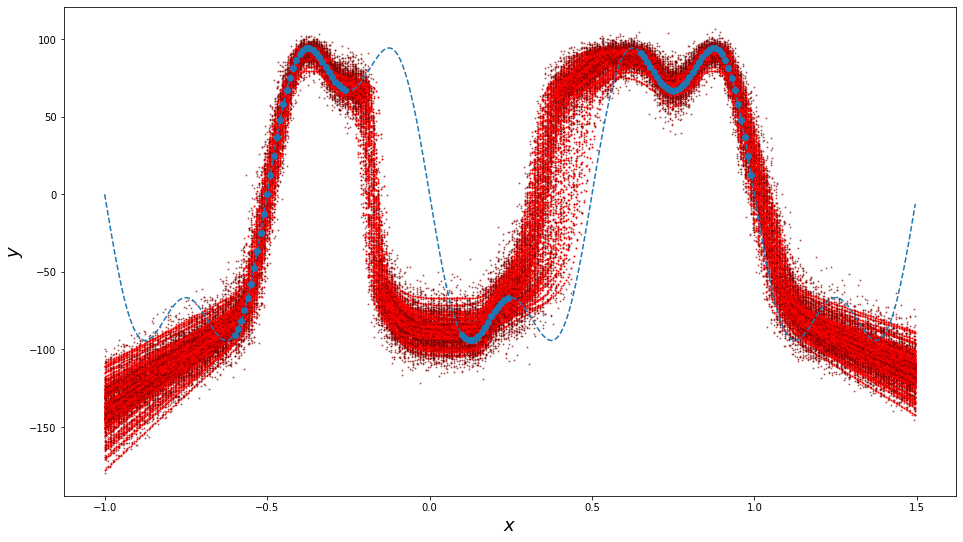

In [10]:
# evaluate single gaussian model
test_x = np.arange(-1.0, 1.5, 0.005)
ret = []
# model.model.resample()
for i, x in enumerate(test_x):
    x = torch.tensor(x[None]).float().to(model.X.device)
    outs = model(x.expand((N_batch, 1)), resample=False)
    y = torch.cat(outs[:2], -1)
    ret.append(y.cpu().detach().numpy())
    torch.cuda.empty_cache()
ret = np.stack(ret)
ret = ret.transpose(1, 0, 2)
torch.cuda.empty_cache()
for i in range(3):
    gc.collect()
plt.figure(figsize=(16, 9))
nc = ret.shape[-2]
colors = np.array(list(plt.cm.rainbow_r(np.linspace(0, 1, nc))))
for i in range(len(ret)):
    m, logS = ret[i, :, 0], ret[i, :, 1]
    samples = gaussian_sample(m, logS)
    plt.scatter(test_x, m, c=colors[0:1], s=1)
    plt.scatter(test_x, samples, c=colors[0:1]*0.5, s=1)
plt.plot(test_x, f(test_x), linestyle='--', label='true function')
plt.scatter(X.cpu().numpy().flatten(), Y.cpu().numpy().flatten())
plt.xlabel('$x$', fontsize=18)
plt.ylabel('$y$', fontsize=18)

print(model)

In [14]:
utils.train_regressor(
    mmodel, iters=4000, batchsize=N_batch, resample=True, optimizer=opt2,
    log_likelihood=losses.gaussian_mixture_log_likelihood, summary_writer=writer, summary_scope='gaussian_mixture_%d' % n_components)

log-likelihood of data: 3.149781: 100%|█████████▉| 3995/4000 [01:00<00:00, 64.72it/s]


Regressor(
  (model): BSequential(
    (fc0): Linear(in_features=1, out_features=200, bias=True)
    (nonlin0): ReLU()
    (drop0): CDropout(rate=[mean: 0.1000000387430191, min: 0.10000002384185791, max: 0.10000002384185791], regularizer_scale=0.10000000149011612)
    (fc1): Linear(in_features=200, out_features=200, bias=True)
    (nonlin1): ReLU()
    (drop1): CDropout(rate=[mean: 0.1000000387430191, min: 0.10000002384185791, max: 0.10000002384185791], regularizer_scale=0.10000000149011612)
    (fc2): Linear(in_features=200, out_features=200, bias=True)
    (nonlin2): ReLU()
    (drop2): CDropout(rate=[mean: 0.1000000387430191, min: 0.10000002384185791, max: 0.10000002384185791], regularizer_scale=0.10000000149011612)
    (fc3): Linear(in_features=200, out_features=200, bias=True)
    (nonlin3): ReLU()
    (drop3): CDropout(rate=[mean: 0.1000000387430191, min: 0.10000002384185791, max: 0.10000002384185791], regularizer_scale=0.10000000149011612)
    (fc4): Linear(in_features=200, out_

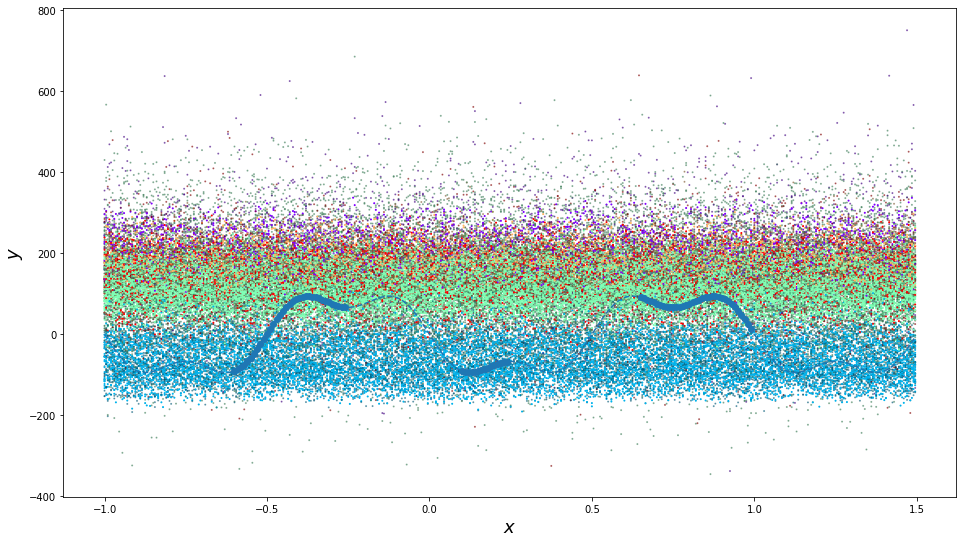

In [7]:
# evaluate mixture density network
test_x = np.arange(-1.0, 1.5, 0.005)
ret = []
logit_weights = []
# mmodel.model.resample()
for i, x in enumerate(test_x):
    x = torch.tensor(x[None]).float().to(mmodel.X.device)
    outs = mmodel(x.expand((N_batch, 1)), resample=False)
    y = torch.cat(outs[:2], -2)
    ret.append(y.cpu().detach().numpy())
    logit_weights.append(outs[2].cpu().detach().numpy())
    torch.cuda.empty_cache()
ret = np.stack(ret)
ret = ret.transpose(1, 0, 2, 3)
logit_weights = np.stack(logit_weights)
logit_weights = logit_weights.transpose(1, 0, 2)
torch.cuda.empty_cache()
for i in range(3):
    gc.collect()

plt.figure(figsize=(16, 9))
nc = ret.shape[-1]
colors = np.array(list(plt.cm.rainbow_r(np.linspace(0, 1, nc))))
total_samples = []
for i in range(len(ret)):
    m, logS = ret[i, :, 0, :], ret[i, :, 1, :]
    samples, c = mixture_sample(m, logS, logit_weights[i], colors)
    plt.scatter(test_x, samples, c=c*0.5, s=1)
    samples, c = mixture_sample(m, logS, logit_weights[i], colors, noise=False)
    plt.scatter(test_x, samples, c=c, s=1)
    total_samples.append(samples)
total_samples = np.array(total_samples)
plt.plot(test_x, f(test_x), linestyle='--', label='true function')
plt.scatter(X.cpu().numpy().flatten(), Y.cpu().numpy().flatten())
plt.xlabel('$x$', fontsize=18)
plt.ylabel('$y$', fontsize=18)

print(mmodel)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyModule(nn.Module):
    def __init__(self):
        super(MyModule, self).__init__()
        # torch.jit.trace produces a ScriptModule's conv1 and conv2
        self.conv1 = torch.jit.trace(nn.Conv2d(1, 20, 5), torch.rand(1, 1, 16, 16))
        self.conv2 = torch.jit.trace(nn.Conv2d(20, 20, 5), torch.rand(1, 20, 16, 16))

    def forward(self, input):
      input = F.relu(self.conv1(input))
      input = F.relu(self.conv2(input))
      return input

scripted_module = torch.jit.script(MyModule())

TypeError: module, class, method, function, traceback, frame, or code object was expected, got MyModule

In [16]:
a = torch.randn(10)

In [17]:
a

tensor([-1.4832,  0.4721, -0.4870, -2.0745,  2.2817, -1.1020, -0.8205,  1.1473,
         0.0607,  1.3696])

In [20]:
torch.softmax(a/1000000, -1)

tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000])

In [11]:
import inspect
inspect.getsource(MyModule().__class__)

TypeError: <module '__main__'> is a built-in class